In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/BEAUSKIN ML/chatbot dataset/skin_treatment_chatbot.json') as file:
    data = json.load(file)

In [ ]:
print(data)

{'intents': [{'tag': 'greeting', 'input': ['Hi', 'Hello', 'Hey', 'Good morning', 'Good evening', 'Hi there', 'Hello there', 'Greetings'], 'responses': ['Hello! How can I assist you with your skincare today?', 'Hi there! How can I help with your skincare routine?', 'Hey! What skincare help do you need today?', 'Good to see you! What skincare questions do you have?']}, {'tag': 'common_skin_issues', 'input': ['What are common skin issues?', 'What are the most common skin problems?', 'What issues do people usually have with their skin?', 'What skin concerns should I be aware of?', 'What are common problems with skin care?'], 'responses': ['Some common skin issues include acne, dry skin, oily skin, hyperpigmentation, and signs of aging like wrinkles and fine lines.', "Skin problems can range from acne and dryness to oily skin, enlarged pores, and redness. It's important to understand your specific skin type to address these issues effectively.", 'The most common skin concerns are acne, dry 

In [ ]:
tags = []
inputs = []
responses = {}
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [ ]:
df = pd.DataFrame({"inputs": inputs, "tags": tags})

In [ ]:
df

,inputs,tags
0,Hi,greeting
1,Hello,greeting
2,Hey,greeting
3,Good morning,greeting
4,Good evening,greeting
...,...,...
77,See you,goodbye
78,Bye,goodbye
79,Take care,goodbye
80,Talk to you later,goodbye


preprocessing

In [ ]:
#removing punctuations
import string
df['inputs'] = df['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df['inputs'] = df['inputs'].apply(lambda wrd: ''.join(wrd))
df

,inputs,tags
0,hi,greeting
1,hello,greeting
2,hey,greeting
3,good morning,greeting
4,good evening,greeting
...,...,...
77,see you,goodbye
78,bye,goodbye
79,take care,goodbye
80,talk to you later,goodbye


No charts were generated by quickchart


In [ ]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['inputs'])
train = tokenizer.texts_to_sequences(df['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the output
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df['tags'])

In [ ]:
input_shape = x_train.shape[1]
print(input_shape)

13


In [ ]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length : ", output_length)

number of unique words :  120
output length :  13


neural network

In [ ]:
#creating the model
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)

In [ ]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
#training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.1491 
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1462 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1448 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1417 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.1432 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1352
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.1422 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.1323
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.1259
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.1228 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.1360 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0

Text(0.5, 0, 'epoch')

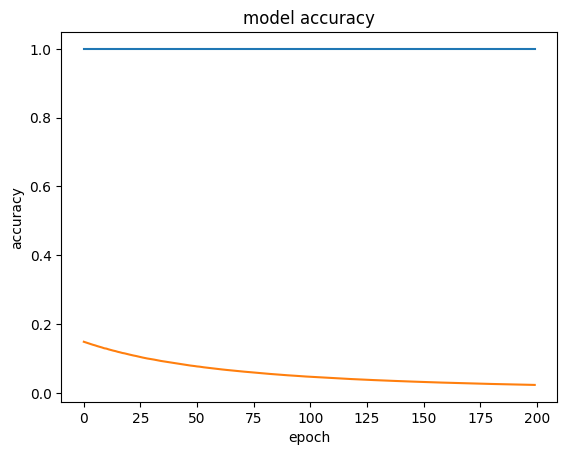

In [ ]:
#plot accuracy
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [31]:
#chatting
import random
while True:
  texts_p = []
  prediction_input = input('You : ')
  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)
  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)
  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()
  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("beaukin: ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
beaukin:  Good to see you! What skincare questions do you have?
You : i dont know my skin type
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
beaukin:  To determine your skin type, wash your face with a gentle cleanser, wait for about an hour without applying any products, then observe your skin. If it feels tight or flaky, you have dry skin. If it’s shiny all over, you have oily skin. If only your T-zone (forehead, nose, chin) is shiny, you likely have combination skin. If it feels comfortable and balanced, you have normal skin.
You : i have acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
beaukin:  For stubborn acne, seek advice from a dermatologist who might recommend prescription treatments like topical antibiotics or oral medications.
You : another tips for acne skin ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
beaukin:  Avoid picking at blemishes to reduce the risk of scarring. Use a lightweight moisturizer to keep your skin hydrated without clogging po

In [ ]:
print(tf.__version__)

2.17.0


In [33]:
model.save('/content/drive/MyDrive/BEAUSKIN ML/model/chatbot_model.h5')